In [1]:
import intake
import cartopy.crs as ccrs
import cartopy.feature as cf
import cmocean
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import xarray as xr
import easygems.healpix as egh


# Load catalog and dataset

In [2]:
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")["EU"]
list(cat)

['CERES_EBAF',
 'ERA5',
 'IR_IMERG',
 'JRA3Q',
 'MERRA2',
 'arp-gem-1p3km',
 'arp-gem-2p6km',
 'casesm2_10km_nocumulus',
 'icon_d3hp003',
 'icon_d3hp003aug',
 'icon_d3hp003feb',
 'icon_ngc4008',
 'ifs_tco2559_rcbmf',
 'ifs_tco3999-ng5_deepoff',
 'ifs_tco3999-ng5_rcbmf',
 'ifs_tco3999-ng5_rcbmf_cf',
 'ifs_tco3999_rcbmf',
 'nicam_220m_test',
 'nicam_gl11',
 'scream-dkrz',
 'tracking-d3hp003',
 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_glm_n1280_CoMA9_TBv1p2',
 'um_glm_n1280_GAL9',
 'um_glm_n2560_RAL3p3']

### define model run, zoom level, and output frequency

In [212]:
outpt_int = ""       # use default output as a default

#model_run = "icon_d3hp003"
#zoom_level = 11

#model_run = "ERA5"
#zoom_level = 8

#model_run = "nicam_gl11"
#zoom_level = 9

#model_run = "ifs_tco3999_rcbmf"
#zoom_level = 7   # 11
#outpt_int = "P1M" 

model_run = "scream-dkrz"
zoom_level = 10
#outpt_int = "PT3H"

pd.DataFrame(cat[model_run].describe()["user_parameters"])

,name,description,type,allowed,default
0,time,time resolution of the dataset,str,"[P1D, PT1H, PT3H]",PT1H
1,zoom,zoom resolution of the dataset,int,"[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]",2


In [214]:
if (outpt_int != ""):
    ds = cat[model_run](zoom=zoom_level,time=outpt_int).to_dask() 
else:
    ds = cat[model_run](zoom=zoom_level).to_dask()

if model_run == "ifs_tco3999_rcbmf":
    ds = ds.rename_dims({'value': 'cell'})

if model_run == "ERA5":
    ds['lon'] = ds['lon'].load()

if model_run != "ERA5":
    ds = egh.attach_coords(ds)

/work/mh0066/m218038/environments/easy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


# Function for computation of time mean precipitation

In [216]:
def compute_total_precip(ds, model_run):
    var = 'pr'
    fctr_time = 1.
    time=slice("2020-03", "2021-02")
    
    if model_run == "ERA5" or model_run == "ifs_tco3999_rcbmf":
        var = 'tp'
        
    if model_run == "ifs_tco3999_rcbmf":
        if outpt_int == "P1M":
            fctr_time = 1./(3.6*24.*30.)   # convert m/month to mm/s (assuming months of 30 days length)
        else:
            fctr_time = 1./3.6   # convert m/h to mm/s
            
    if model_run == "ERA5":
        fctr_time = 1./(3.6*24)   # convert m/day to mm/s
    if model_run == "scream-dkrz":
        time=slice("2019-09", "2020-08")
        if outpt_int == "PT3H":
            fctr_time = 3000.   # convert m/s to mm/s
        else:
            fctr_time = 1000.   # convert m/s to mm/s
        

    pr = ds[var].where(mask,drop=True).sel(time=time)
    dt = pr['time'].diff('time') / np.timedelta64(1, 's')
    dt = np.append(dt, dt[-1])
    dt_da = xr.DataArray(dt, coords={"time": pr.time}, dims="time")
    
    return (pr * dt_da).sum(dim='time')*fctr_time

# Select Region

In [217]:
#select region

region="greenland"
#region="svalbard"
#region="antarctica"
#region="tibet"

if (region == "svalbard"):
    extent_data = [5, 35, 75, 83]
    extent_plot = [5, 35, 75, 81]
    central_latitude=80
    central_longitude=20
elif (region == "greenland"):
    extent_data = [280, 355, 58, 85]
    extent_plot = [285, 350, 55, 88]
    central_latitude=70
    central_longitude=-42
elif (region == "antarctica"):
    extent_data = [0, 360, -90, -60]
    extent_plot = [0, 360, -90, -58]
    central_latitude=-90
    central_longitude=0
elif (region == "tibet"): 
    extent_data = [65, 115, 25, 45]
    extent_plot = [70, 110, 25, 45]
    central_latitude=0
    central_longitude=90    
else:
    print("region not defined")

mask = (
    (ds.lon > extent_data[0])
    & (ds.lon < extent_data[1])
    & (ds.lat > extent_data[2])
    & (ds.lat < extent_data[3])
)


# Precipitation

In [218]:
ds_pr = compute_total_precip(ds, model_run)

<function matplotlib.pyplot.show(close=None, block=None)>

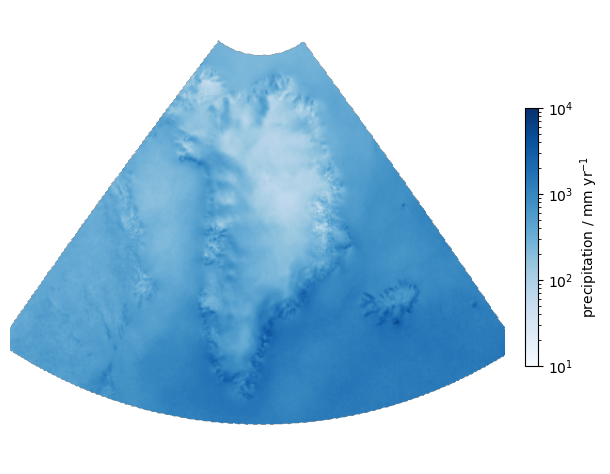

In [219]:
# plot precipitation

if (region == "tibet"):
    projection = ccrs.Robinson(central_longitude=central_longitude, globe=None)
else:
    projection = ccrs.Stereographic(central_latitude=central_latitude, central_longitude=central_longitude)

fig, ax = plt.subplots(
    figsize=(6, 12), 
    subplot_kw={"projection": projection}, 
    constrained_layout=True
)
ax.set_extent(extent_plot, crs=ccrs.PlateCarree())

# Use LogNorm for log-scale
vmin = 10.
vmax=10000.
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)


im = egh.healpix_show(ds_pr, ax=ax, cmap='Blues', norm=norm)
#ax.add_feature(cf.COASTLINE, linewidth=0.8)
ax.add_feature(cf.BORDERS, linewidth=0.4)

# Add gridlines
#ax.gridlines(draw_labels=False, dms=False, x_inline=False, y_inline=False)

# Remove the frame
ax.spines['geo'].set_visible(False)

# Add a colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.026, pad=0.04)
cbar.set_label('precipitation / mm yr$^{-1}$')  # Set the label for the colorbar

fig_fname = "figs/"+"precip_"+region+"_"+model_run+"_zl"+str(zoom_level)+".png"
plt.savefig(fig_fname, dpi=200, facecolor='white',bbox_inches='tight')

plt.show


# Surface temperature

In [193]:
var = "tas"
if model_run == "ERA5" or model_run == "ifs_tco3999_rcbmf":
        var = "2t"
    
ds_t = ds[var].where(mask,drop=True).sel(time=slice("2020-03", "2021-02")).mean(dim='time')


<function matplotlib.pyplot.show(close=None, block=None)>

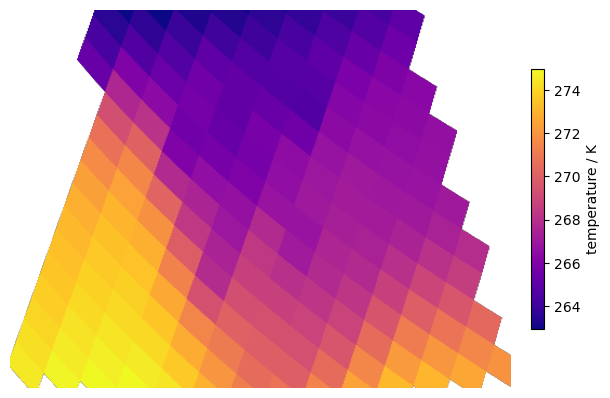

In [194]:
# plot temperature

if (region == "tibet"):
    projection = ccrs.Robinson(central_longitude=central_longitude, globe=None)
else:
    projection = ccrs.Stereographic(central_latitude=central_latitude, central_longitude=central_longitude)

fig, ax = plt.subplots(
    figsize=(6, 12), 
    subplot_kw={"projection": projection}, 
    constrained_layout=True
)
ax.set_extent(extent_plot, crs=ccrs.PlateCarree())


im = egh.healpix_show(ds_t, ax=ax, cmap='plasma')
#ax.add_feature(cf.COASTLINE, linewidth=0.8)
ax.add_feature(cf.BORDERS, linewidth=0.4)

# Add gridlines
#ax.gridlines(draw_labels=False, dms=False, x_inline=False, y_inline=False)

# Remove the frame
ax.spines['geo'].set_visible(False)

# Add a colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.026, pad=0.04)
cbar.set_label('temperature / K')  # Set the label for the colorbar

fig_fname = "figs/"+"t_"+region+"_"+model_run+"_zl"+str(zoom_level)+".png"
plt.savefig(fig_fname, dpi=200, facecolor='white',bbox_inches='tight')

plt.show

# Orography

In [195]:
ds_orog = ds.orog.where(mask,drop=True)

AttributeError: 'Dataset' object has no attribute 'orog'

<function matplotlib.pyplot.show(close=None, block=None)>

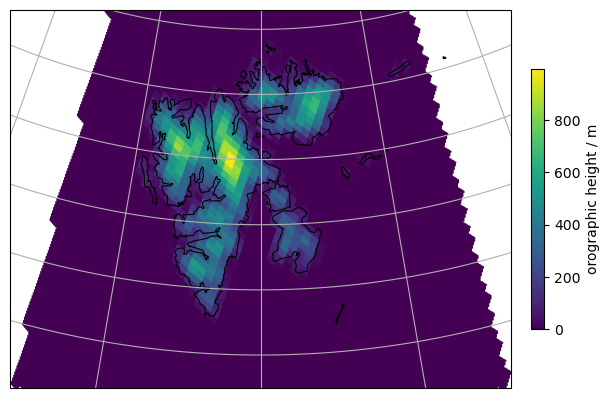

In [15]:
# plot orography

ds_toplot = ds_orog

projection = ccrs.Stereographic(central_latitude=central_latitude, central_longitude=central_longitude)

fig, ax = plt.subplots(
    figsize=(6, 12), 
    subplot_kw={"projection": projection}, 
    constrained_layout=True
)
ax.set_extent(extent_plot, crs=ccrs.PlateCarree()) # Greenland

im = egh.healpix_show(ds_toplot, ax=ax, cmap='viridis')
ax.add_feature(cf.COASTLINE, linewidth=0.8)
ax.add_feature(cf.BORDERS, linewidth=0.4)
# Add gridlines
ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)

# Add a colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.026, pad=0.04)
cbar.set_label('orographic height / m')  # Set the label for the colorbar

fig_fname = "figs/"+"orog_"+region+"_"+model_run+"_zl"+str(zoom_level)+".png"
plt.savefig(fig_fname, dpi=200, facecolor='white',bbox_inches='tight')

plt.show